In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../orca') # add ORCA-main directory
sys.path.append('../tests') # add tests folder in ORCA-main directory
from data.SamplePKLFile import generate_matrices_pkl_from_csv
from ORCA.Optimization.LTIStateSpaceMPCPyomoOptimization import LTIStateSpaceMPCPyomoOptimization
from ORCA.RewardForecast.StaticHistoricalForecast import StaticHistoricalForecast
from ORCA.RewardForecast.SinusoidalForecast import SinusoidalForecast
import pickle
import datetime
import csv

from fmpy import *

### Operational scheme
This script loads functional mock-up units (FMU) generated by Dymola. Based on the initial conditions, ORCA find optimal charge and discharge rates that maximize rewards. Starting from the end states at previous time step, both rates are sent to FMU to simulate the battery state of charge (SOC) for a fixed duration of time. Simulated SOC at the last step is sent back to ORCA for next iterations.  

### FMU
The FMU is an independent executable in standard formats for model exchange (ME) and co simulation (CO). The major difference between is time stepping, where ME takes fixed time steps and CO takes adaptive time steps. CO has better numerical stability, and they produce the same result for battery model. ME is used in this study. 
#### importan assumptions:
All control actions are linearly interpolated from the start to the end time step.
All simulation time needs to be reset at every iteration

### ORCA

In [2]:
class dymola_battery():
    def __init__(self,fmu_file):
        assert os.path.isfile(
            fmu_file
        ), f"{fmu_file} file for dymola FMU not found."
        self.fmu_file = fmu_file
        
    def run_fmu(self,fmu_input,fmu_output):
        results = simulate_fmu(self.fmu_file,
                               start_values={'InitialEnergyStored':(fmu_input['soc_start'],'Wh'),
                                             'DC_PyomoABC.table[1,2]': fmu_input['dc_start'],
                                             'DC_PyomoABC.table[2,2]': fmu_input['dc_end'],
                                             'C_PyomoABC.table[1,2]': fmu_input['c_start'],
                                             'C_PyomoABC.table[2,2]': fmu_input['c_end'],},
                               # reset simulation time
                               start_time = fmu_input['time_start']-fmu_input['time_start'],
                               stop_time = fmu_input['time_end']-fmu_input['time_start'],
                               validate = False,
                               output = [
                                   'battery.StateOfCharge_Wh',  # absolute state of charge
                               ],
                               fmi_call_logger=None)
        for i in range(len(results)):
            fmu_output['result_time'].append(results[i][0]+fmu_input['time_start'])
            fmu_output['result_soc'].append(results[i][1])
        
        fmu_output['disc_time'].append(fmu_output['result_time'][-1])
        fmu_output['disc_soc'].append(fmu_output['result_soc'][-1])
        
        if connect_deeplynx == True:
            # dump FMU inputs to Deep Lynx
            dataframe_name = dataframe_folder+'/FMU_to_ORCA_'+current_time.strftime('%m%d%Y_%H%M%S')+'.csv'
            with open(dataframe_name,'w',newline='') as file:
                writer = csv.writer(file)
                writer.writerow(['time','soc'])
                writer.writerow([fmu_output['result_time'][-1],fmu_output['result_soc'][-1]])
        return

In [3]:
def plot_results(current_time, result_df, prediction, rewards):
    
    freq = str(opt_specs['dt'])+'min'
    periods = int(opt_specs['t_window']/opt_specs['dt'])+1
    pred_time = pd.date_range(start=current_time,periods = periods, freq = freq)
    
    fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 8),dpi=200)
    fig.subplots_adjust(hspace=0.4)
    
    ax[0].set_title('charging and discharging rate',fontweight="bold",fontsize=16)
    ax[0].plot(result_df['Time'], result_df['qC'], 'b-', label='charging')
    ax[0].plot(result_df['Time'], result_df['qD'], 'r-',label='discharging')
    
    ax[0].plot(result_df['Time'].iloc[-1], result_df['qC'].iloc[-1], 'b*')
    ax[0].plot(result_df['Time'].iloc[-1], result_df['qD'].iloc[-1], 'r*')
    
    ax[0].plot(pred_time[0:-3], prediction[1][0:-2], 'b--', label='charging prediction')
    ax[0].plot(pred_time[0:-3], prediction[2][0:-2], 'r--', label='discharging prediction')
    ax[0].set_ylim(bottom=-5, top=20.0+5)
    
    ax[0].set_ylabel('MW',fontsize=18)
    ax[0].legend(fontsize=16,loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].tick_params(axis='y', labelsize=18)

    ax[1].set_title('state of charge',fontweight="bold",fontsize=16)
    #ax[1].plot(result_df['Time'], result_df['SOC'], 'r', label='State of Charge')
    ax[1].plot(result_df['Time'], result_df['SOC'], 'r.', label='SOC by ORCA')
    ax[1].plot(result_df['Time'], result_df['SOC2'], 'b', label='SOC by FMI')
    ax[1].plot(result_df['Time'].iloc[-1], result_df['SOC2'].iloc[-1], 'b*')
    
    ax[1].plot(pred_time[1:-3], prediction[0][2:-1], 'r--', label='SOC prediction')
    
    #ax[1].plot(result_df['Time'],command_fmu['output']['disc_soc'], label='FMU State of Charge')
    #ax[1].plot(result_df['Time'],command_fmu['output']['disc_soc'], label='FMU State of Charge')
    ax[1].set_ylim(bottom=-5, top=20+5)
    ax[1].set_ylabel('MWh',fontsize=18)
    ax[1].legend(fontsize=16,loc='center left', bbox_to_anchor=(1, 0.5))
    ax[1].tick_params(axis='y', labelsize=18)

    ax[2].set_title('market price',fontweight="bold",fontsize=16)
    ax[2].plot(result_df['Time'], result_df['LMP'], 'y',label='Price')
    ax[2].plot(pred_time[0:-2], rewards[0:-1], 'y--', label='Price prediction')
    ax[2].set_ylim(bottom=0, top=result_df['LMP'].max()+5)
    ax[2].set_ylabel('$/MW',fontsize=18)
    ax[2].legend(fontsize=16,loc='center left', bbox_to_anchor=(1, 0.5))
    ax[2].tick_params(axis='both', labelsize=10)
    
    figname = figure_folder+'/'+current_time.strftime('%m%d%Y_%H%M%S')+'.png'
    plt.savefig(fname=figname,bbox_inches='tight')
    plt.close()

In [18]:
import importlib

#from ORCA.Optimization.LTIStateSpaceMPCPyomoOptimization import LTIStateSpaceMPCPyomoOptimization

importlib.reload(sys.modules['ORCA.Optimization.LTIStateSpaceMPCPyomoOptimization'])
from ORCA.Optimization.LTIStateSpaceMPCPyomoOptimization import LTIStateSpaceMPCPyomoOptimization

In [19]:
opt_specs = {'t_window': 300.0, 
             'dt': 5.0,
             'solver': 'glpk',
             'executable': 'C:/Users/linl/OneDrive - Idaho National Laboratory/RTO/orca_dymola/winglpk-4.65/w64/glpsol.exe',
             'matrices': 'C:/Users/linl/OneDrive - Idaho National Laboratory/RTO/orca_dymola/orca/tests/data/RAVENDMDc.xml',
             #'matrices': 'C:/Users/LINL/OneDrive - Idaho National Laboratory/RTO/orca-main/tests/data/ABC.pkl',
             'states': {'order': ['qNPP', 'SOC'],
                        'lb': [0.0, 0.001],
                        'ub': [50.0, 20.0]},
             'control': {'order': ['qC', 'qD'],
                         'lb': [0, 0],
                         'ub': [20.0, 20.0]},
             'measurements': {'order': ['SOC2'],
                              'lb': [0.0],
                              'ub': [20.0]},
             'objective': {'LMP': {'state_multiplier': [1.0, 0.0],
                                   'control_multiplier': [-1.0, 1.0],
                                   'measurement_multiplier': [0.0]},
                           'sense': 'maximize'}}
optimize = LTIStateSpaceMPCPyomoOptimization(**opt_specs)

In [20]:
reward_specs = {'t_window': 300.0, 
                'dt': 5.0, 
                'amplitude': 20.0,
                'phase': np.pi/4.0, 
                'frequency': 2.0*np.pi/144.0,
                'offset': 40.0}
#rewards = StaticHistoricalForecast(**reward_specs)
rewards = SinusoidalForecast(**reward_specs)

In [21]:
make_animation =True
connect_deeplynx = True

figure_folder = 'figures'
dataframe_folder = 'dataframe'

if make_animation == True:    
    if not os.path.exists(figure_folder):
        os.mkdir(figure_folder)
        
if connect_deeplynx == True:    
    if not os.path.exists(dataframe_folder):
        os.mkdir(dataframe_folder)

In [22]:
initial_time = pd.to_datetime('2022-05-31 04:00:00')
end_time = pd.to_datetime('2022-06-01 04:00:00')
current_time = initial_time
result_df = None

# initial states
x_init = [50.0, 0.001]
u_init = [0.0, 0.0]

result_pd= {'SOC_prd':[],}

command_fmu = {'input':{'dc_start': None,
                        'dc_end': None,
                        'c_start': None,
                        'c_end': None, 
                        'time_start': None,
                        'time_end':None,
                        'soc_start': max(x_init[1],0.001)
                       },
               'output':{'result_time':[],
                         'result_soc':[],
                         'disc_time':[0.0],
                         'disc_soc':[x_init[1]]},
              }

dymola_fmu = dymola_battery(fmu_file = '../tests/data/battery.fmu')

In [23]:
while current_time < end_time:
    current_time += pd.Timedelta(minutes=5)
    # generate reward data
    reward = {'LMP': rewards.gen_reward()}
    # get the next dispatch
    result = optimize.return_next_dispatch(reward, x_init)
    #pdb.set_trace()
    # store optimal results in a DataFrame
    optimal_dict = {'Time': [current_time]}
    # store states
    result_pd['SOC_prd'].append(result['states'][1])
    for i in range(len(opt_specs['states']['order'])):
        optimal_dict[opt_specs['states']['order'][i]] = [result['states'][i]]
    # store control
    for i in range(len(opt_specs['control']['order'])):
        optimal_dict[opt_specs['control']['order'][i]] = [result['control'][i]]
    
    # prepare FMU inputs
    command_fmu['input']['dc_start'] = u_init[0]#optimal_dict[opt_specs['control']['order'][1]][0]#
    command_fmu['input']['dc_end'] = optimal_dict[opt_specs['control']['order'][1]][0]
    command_fmu['input']['c_start'] = u_init[1]#optimal_dict[opt_specs['control']['order'][0]][0]#
    command_fmu['input']['c_end'] = optimal_dict[opt_specs['control']['order'][0]][0]
    
    command_fmu['input']['time_start'] = 0
    command_fmu['input']['time_end'] = 300
    
    if connect_deeplynx == True:
        # dump FMU inputs to Deep Lynx
        dataframe_name = dataframe_folder+'/ORCA_to_FMU_'+current_time.strftime('%m%d%Y_%H%M%S')+'.csv'
        fmu_input = pd.DataFrame(command_fmu['input'],index=[0])
        fmu_input.to_csv(dataframe_name)
    
    print('orca solve successful')
    
    sim_results = dymola_fmu.run_fmu(command_fmu['input'],command_fmu['output'])
    #using simulated or stored data as initial condition for next iterations
    command_fmu['input']['soc_start'] = command_fmu['output']['result_soc'][-1]
    
    for i in range(len(opt_specs['measurements']['order'])):
        optimal_dict[opt_specs['measurements']['order'][i]] = command_fmu['output']['result_soc'][-1]
    # store rewards
    optimal_dict['LMP'] = [reward['LMP'][1]]
    optimal = pd.DataFrame(optimal_dict)
    if result_df is None:
        result_df = optimal
    else:
        result_df = pd.concat([result_df, optimal], ignore_index=True)
        
    if make_animation == True:
        plot_results(current_time, result_df,result['prediction'],reward['LMP'])
        
    # update initial states
    x_init = [50.0, command_fmu['output']['result_soc'][-1]]
    u_init = [optimal_dict[opt_specs['control']['order'][1]][0],optimal_dict[opt_specs['control']['order'][0]][0]]
    
    print(current_time)

orca solve successful
2022-05-31 04:05:00
orca solve successful
2022-05-31 04:10:00
orca solve successful
2022-05-31 04:15:00
orca solve successful
2022-05-31 04:20:00
orca solve successful
2022-05-31 04:25:00
orca solve successful
2022-05-31 04:30:00
orca solve successful
2022-05-31 04:35:00
orca solve successful
2022-05-31 04:40:00
orca solve successful
2022-05-31 04:45:00
orca solve successful
2022-05-31 04:50:00
orca solve successful
2022-05-31 04:55:00
orca solve successful
2022-05-31 05:00:00
orca solve successful
2022-05-31 05:05:00
orca solve successful
2022-05-31 05:10:00
orca solve successful
2022-05-31 05:15:00
orca solve successful
2022-05-31 05:20:00
orca solve successful
2022-05-31 05:25:00
orca solve successful
2022-05-31 05:30:00
orca solve successful
2022-05-31 05:35:00
orca solve successful
2022-05-31 05:40:00
orca solve successful
2022-05-31 05:45:00
orca solve successful
2022-05-31 05:50:00
orca solve successful
2022-05-31 05:55:00
orca solve successful
2022-05-31 0

2022-05-31 20:20:00
orca solve successful
2022-05-31 20:25:00
orca solve successful
2022-05-31 20:30:00
orca solve successful
2022-05-31 20:35:00
orca solve successful
2022-05-31 20:40:00
orca solve successful
2022-05-31 20:45:00
orca solve successful
2022-05-31 20:50:00
orca solve successful
2022-05-31 20:55:00
orca solve successful
2022-05-31 21:00:00
orca solve successful
2022-05-31 21:05:00
orca solve successful
2022-05-31 21:10:00
orca solve successful
2022-05-31 21:15:00
orca solve successful
2022-05-31 21:20:00
orca solve successful
2022-05-31 21:25:00
orca solve successful
2022-05-31 21:30:00
orca solve successful
2022-05-31 21:35:00
orca solve successful
2022-05-31 21:40:00
orca solve successful
2022-05-31 21:45:00
orca solve successful
2022-05-31 21:50:00
orca solve successful
2022-05-31 21:55:00
orca solve successful
2022-05-31 22:00:00
orca solve successful
2022-05-31 22:05:00
orca solve successful
2022-05-31 22:10:00
orca solve successful
2022-05-31 22:15:00
orca solve suc

In [24]:
if make_animation == True:
    import imageio  # required to make animation
    images = []
    iset = 1
    
    for footprint in result_df['Time']:
        figname = figure_folder+'/'+footprint.strftime('%m%d%Y_%H%M%S')+'.png'
        images.append(imageio.imread(figname))
        
    #imageio.mimsave('C:/Users/LINL/Pictures/results_'+str(iset)+'.mp4', images)
    iset += 1
if images!=[]:
    imageio.mimsave(figure_folder+'/results_'+str(iset)+'.mp4', images)

C:\Users\LINL\AppData\Local\Temp\2\ipykernel_37600\1904823974.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(figname))
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2409, 1370) to (2416, 1376) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


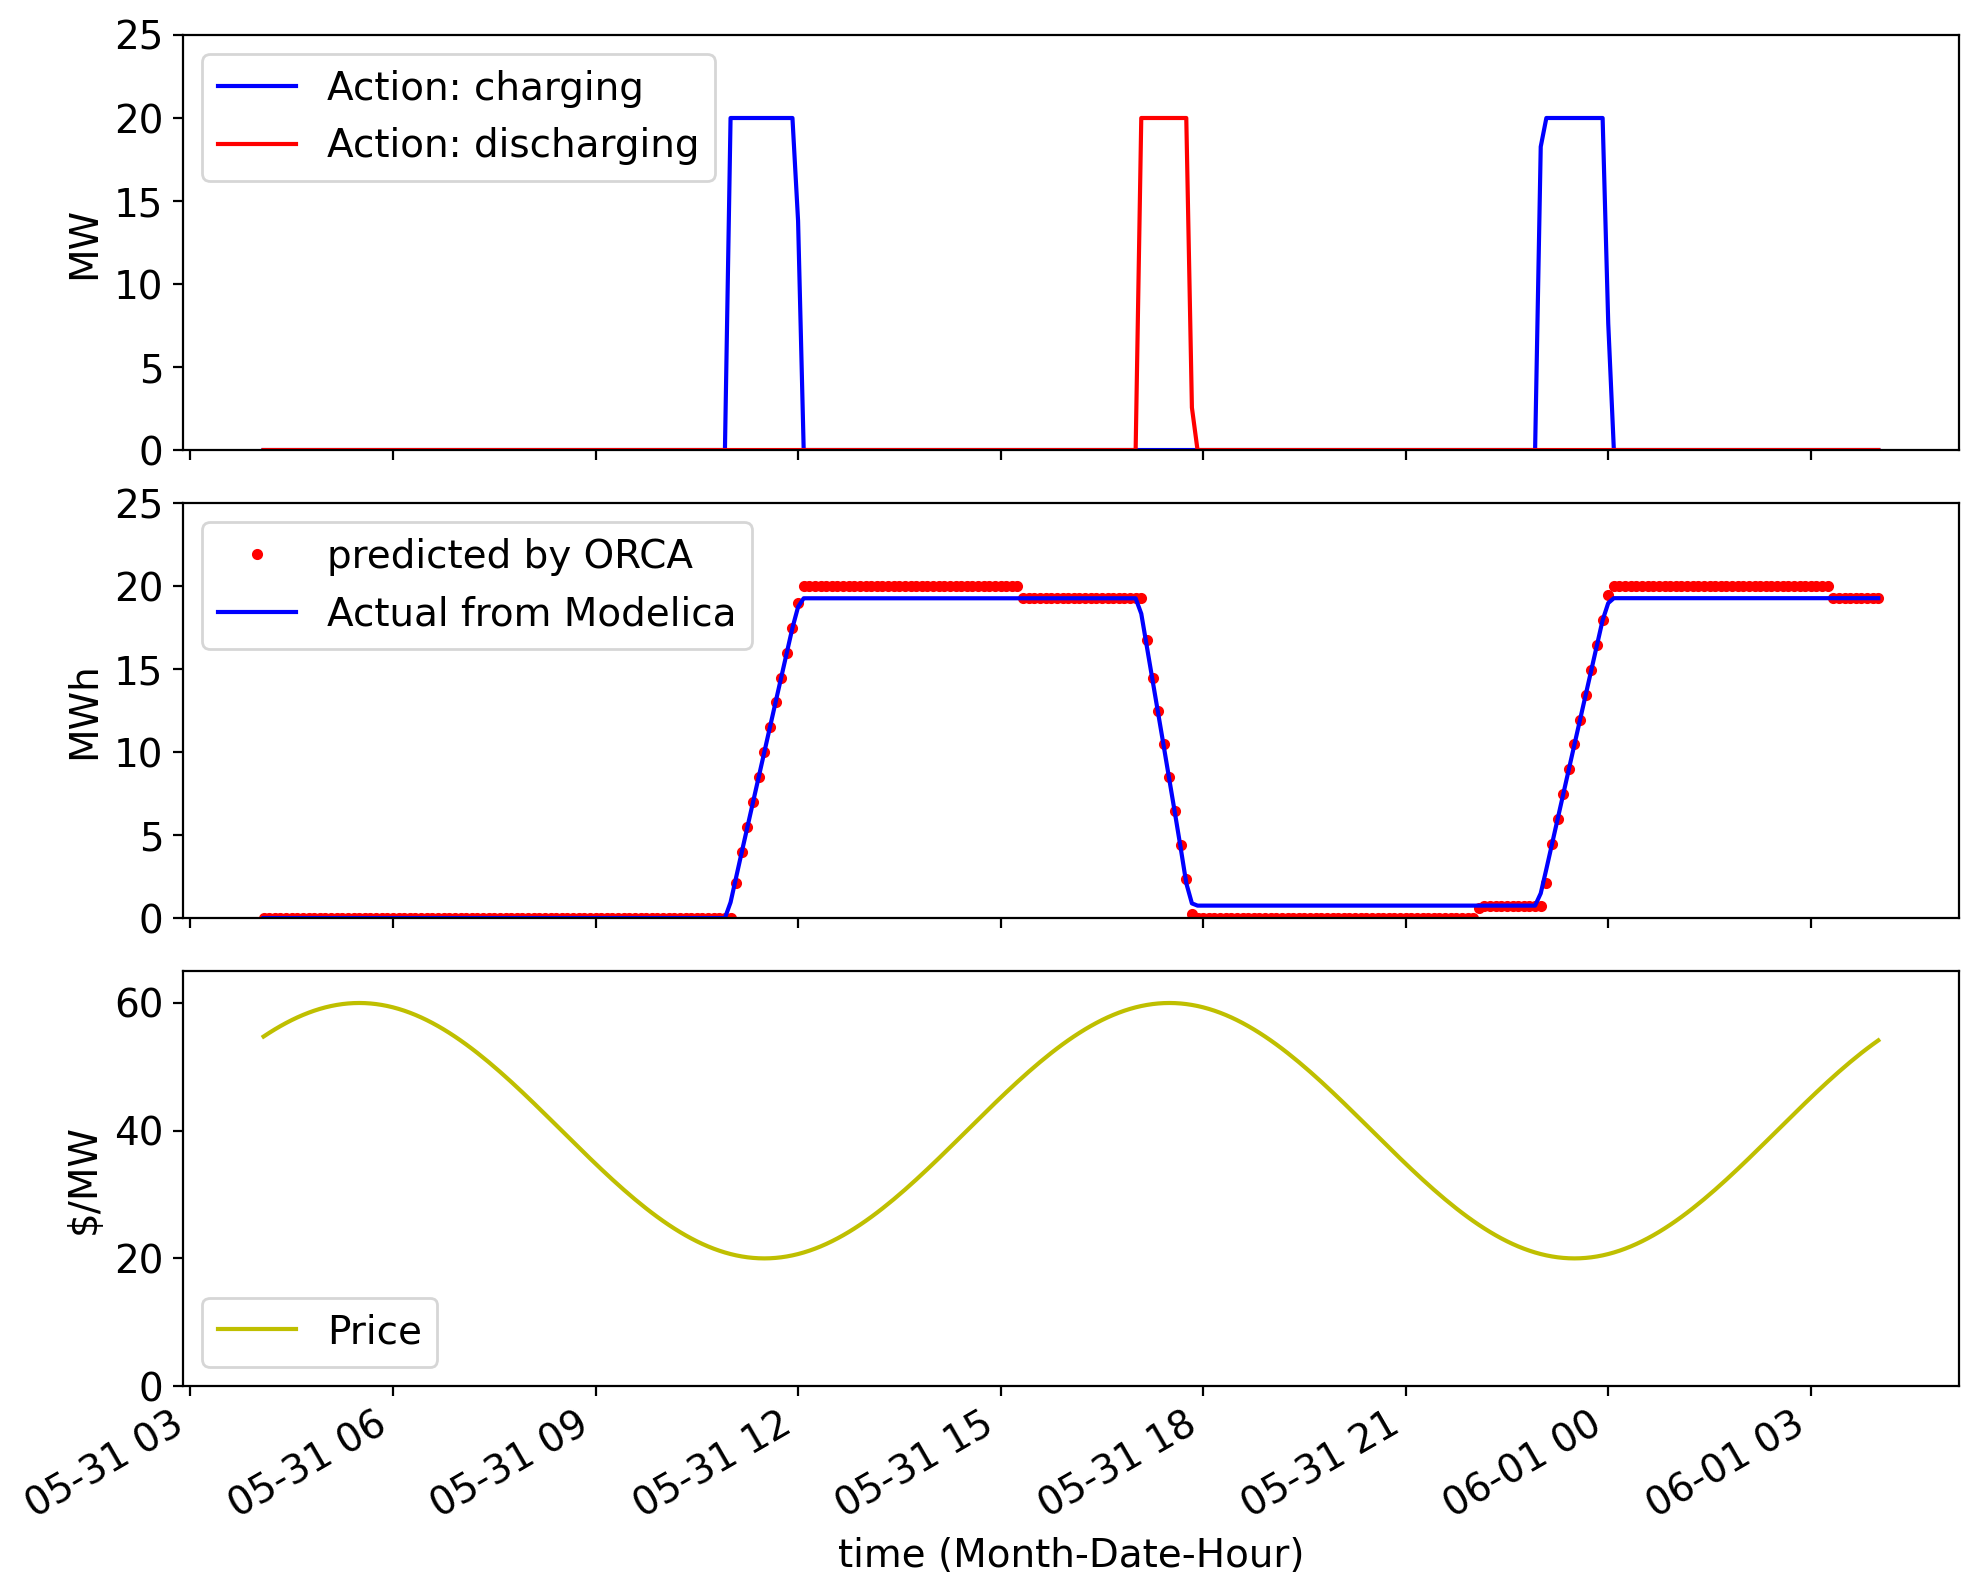

In [25]:
result_df['qRT'] = result_df['qNPP'] - result_df['qC']

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 8),dpi=200)
fig.subplots_adjust(hspace=0.4)

#ax[0].plot(result_df['Time'], result_df['qRT'], label='Real Time')
#ax[0].set_title('charging and discharging rate',fontweight="bold",fontsize=16)
ax[0].plot(result_df['Time'], result_df['qC'], 'b-', label='Action: charging')
#ax[0].plot(result_df['Time'], result_df['q'], label='Storage Charging')
ax[0].plot(result_df['Time'], result_df['qD'], 'r-',label='Action: discharging')
ax[0].set_ylim(bottom=0, top=20.0+5)
ax[0].set_ylabel('MW',fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='y', labelsize=14)

#ax[1].set_title('state of charge (SOC)',fontweight="bold",fontsize=16)
#ax[1].plot(result_df['Time'], result_df['SOC'], 'r', label='State of Charge')
ax[1].plot(result_df['Time'], result_df['SOC'], 'r.', label='predicted by ORCA')
ax[1].plot(result_df['Time'], result_df['SOC2'], 'b', label='Actual from Modelica')
#ax[1].plot(result_df['Time'],command_fmu['output']['disc_soc'], label='FMU State of Charge')
#ax[1].plot(result_df['Time'],command_fmu['output']['disc_soc'], label='FMU State of Charge')
ax[1].set_ylim(bottom=0, top=20+5)
ax[1].set_ylabel('MWh',fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='y', labelsize=14)

#ax[2].set_title('market price',fontweight="bold",fontsize=16)
ax[2].plot(result_df['Time'], result_df['LMP'], 'y', label='Price')
ax[2].set_ylim(bottom=0, top=result_df['LMP'].max()+5)
ax[2].set_ylabel('$/MW',fontsize=14)
ax[2].set_xlabel('time (Month-Date-Hour)',fontsize=14)
ax[2].legend(fontsize=14)
ax[2].tick_params(axis='both', labelsize=14)
fig.autofmt_xdate()
plt.tight_layout()